In [2]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/multi_agent_sim")
from multi_agent_sim import MultiAgentSim

In [3]:
infection_dynamics_params = {
    'forward_gen_alpha': 8,
    'forward_gen_beta_hyperparams': (5,5),
    'detectability_curve_type': 'optimistic',
    'self_reporting_multiplier': 0.8,
    'self_reporting_delay': 3,
    'init_infection_rate': 0.001,
    'use_deterministic_infection_counts': True,
}

social_network_params_high_var = {
    'location_vec_dim': 2,
    'network_gamma': 3,
    'daily_contacts_distn_type': 'negative_binomial',
    'neg_bin_r': 2,
    'neg_bin_p_hyperparams': (2,3),
}

n_agents = 1000
main_params = {
    'n_agents': 1000,
    'use_contact_tracing': False,
    'use_adaptive_testing': True,
    'use_surveillance_testing': True
}

ct_params = {
    'ct_recall_window': 8,
    'ct_delay_distribution': [1/3,1/3,1/3], # uniform over 0, 1, 2 days delay
    'ct_recall_rate': 0.5
}

at_params = {
    'at_delay_distribution': [1/5] * 5,
    'at_net_size_contact_multiplier': 10,
    'at_recall_rate': 0.9
}

st_params = {
    'st_testing_window': 3,
    'st_missed_test_rate': 0.1
}

def init_high_var_sim(R0):
    social_network_params_high_var['neg_bin_r'] = R0 / 0.9
    return MultiAgentSim(main_params, infection_dynamics_params, social_network_params_high_var, 
                         ct_params, at_params, st_params)

social_network_params_low_var = {
    'location_vec_dim': 2,
    'network_gamma': 3,
    'daily_contacts_distn_type': 'negative_binomial',
    'neg_bin_r': 2,
    'neg_bin_p_hyperparams': (5,6),
}

def init_low_var_sim(R0):
    social_network_params_low_var['neg_bin_r'] = R0 / 0.9
    return MultiAgentSim(main_params, infection_dynamics_params, social_network_params_low_var, 
                         ct_params, at_params, st_params)

In [4]:
def sample_trajectory(R0, at_multiplier, st_testing_window):
    st_params['st_testing_window'] = st_testing_window
    at_params['at_net_size_contact_multiplier'] = at_multiplier
    sim = init_low_var_sim(R0)
    infection_counts = [len(sim.infection.get_cum_infected_agent_ids())]
    init_infection_counts = infection_counts[0]
    for _ in range(7*12):
        sim.step()
        infection_counts.append(len(sim.infection.get_cum_infected_agent_ids()))
    total_tests = sim.get_total_tests()
    return total_tests, infection_counts, init_infection_counts, infection_counts[-1]

# look at R0 vs. at_multiplier

In [ ]:
R0s_to_try = [1.5, 2, 2.5, 3, 3.5]

st_windows_to_try = [5, 8, 12]
at_mults_to_try = [6, 10, 14]

st_at_pareto_results = {}

main_params['use_contact_tracing'] = False

ntrajectories = 20

from datetime import datetime

for R0 in R0s_to_try:
    for st_window in st_windows_to_try:
        for mult in at_mults_to_try:
            print("on pair {}".format((R0, mult, st_window)))
            print("Timestamp: {}\n".format(datetime.now()))
            st_at_pareto_results[(R0, mult, st_window)] = [sample_trajectory(R0, mult, st_window) for _ in range(ntrajectories)]

on pair (1.5, 6, 5)
Timestamp: 2020-11-18 16:48:55.979875

on pair (1.5, 10, 5)
Timestamp: 2020-11-18 16:54:48.891967

on pair (1.5, 14, 5)
Timestamp: 2020-11-18 17:00:46.776849

on pair (1.5, 6, 8)
Timestamp: 2020-11-18 17:06:42.516685

on pair (1.5, 10, 8)
Timestamp: 2020-11-18 17:12:41.411387

on pair (1.5, 14, 8)
Timestamp: 2020-11-18 17:18:39.526113

on pair (1.5, 6, 12)
Timestamp: 2020-11-18 17:24:38.284558

on pair (1.5, 10, 12)
Timestamp: 2020-11-18 17:30:36.408201

on pair (1.5, 14, 12)
Timestamp: 2020-11-18 17:36:37.441713

on pair (2, 6, 5)
Timestamp: 2020-11-18 17:42:37.145895

on pair (2, 10, 5)
Timestamp: 2020-11-18 17:48:36.426855

on pair (2, 14, 5)
Timestamp: 2020-11-18 17:54:37.666053

on pair (2, 6, 8)
Timestamp: 2020-11-18 18:00:36.755007

on pair (2, 10, 8)
Timestamp: 2020-11-18 18:06:35.593840

on pair (2, 14, 8)
Timestamp: 2020-11-18 18:12:36.964817

on pair (2, 6, 12)
Timestamp: 2020-11-18 18:18:34.840776

on pair (2, 10, 12)
Timestamp: 2020-11-18 18:24:40.15424

# look at results

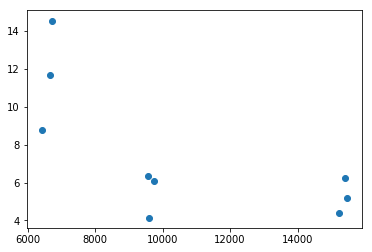

In [6]:
R0 = 1.5
tests = []
infxns = []
for st_window in st_windows_to_try:
    for mult in at_mults_to_try:
        results = st_at_pareto_results[(R0, mult, st_window)]
        avg_total_tests = np.mean([r[0] for r in results])
        avg_total_infxns = np.mean([r[-1] for r in results])
        tests.append(avg_total_tests)
        infxns.append(avg_total_infxns)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(tests, infxns)

In [8]:
import pickle
pickle.dump(st_at_pareto_results, open("st_at_pareto_results.pickle", "wb"))